In [1]:
# Imports
import numpy as np
import torch

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.analysis import load_tensorboard

from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic
from DeePyMoD_SBL.deepymod_torch.estimators import Threshold

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
v = 0.1
A = 1.0

# Making grid
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train, rand_idx = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.05, random=True, return_idx=True)

In [7]:
# Making data
estimator = Threshold(0.1)

config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 3}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True)

In [8]:
train_dynamic(model, X_train, y_train, optimizer, 5000, stopper_kwargs={'ini_epoch':10}, log_dir='runs/testing/')

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
        100      2.00%             154s   -4.53e+00   1.62e-02   5.70e-04   1.60e+01 Updating mask.
        300      6.00%             140s   -8.85e+00   1.82e-03   1.68e-04   5.58e+00 Updating mask.
        600     12.00%             132s   -1.33e+01   1.59e-04   7.99e-05   6.57e+00 Updating mask.
       3950     79.00%               0s   -1.51e+01   8.39e-05   9.20e-07   1.58e+00 Updating mask.
       4450     89.00%               0s   -1.51e+01   8.40e-05   8.74e-07   1.54e+00 Updating mask.
5


In [9]:
model.constraints.sparsity_mask

[tensor([False, False,  True, False, False,  True, False, False, False, False,
         False, False])]

In [10]:
model.sparsity_estimator.coef_

array([ 0.        ,  0.        ,  0.65419674,  0.        ,  0.        ,
       -0.89547694,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [11]:
df_part1 = load_tensorboard('runs/testing/')

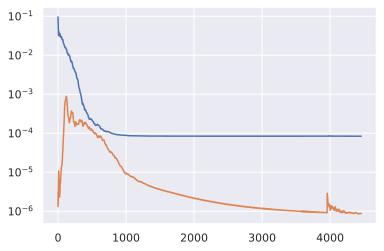

In [12]:
plt.semilogy(df_part1.index, df_part1['MSE_0'])
plt.semilogy(df_part1.index, df_part1['Regression_0'])

In [13]:
df_part1.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'coeff_0_9', 'coeff_0_10', 'coeff_0_11',
       'scaled_coeff_0_0', 'scaled_coeff_0_1', 'scaled_coeff_0_2',
       'scaled_coeff_0_3', 'scaled_coeff_0_4', 'scaled_coeff_0_5',
       'scaled_coeff_0_6', 'scaled_coeff_0_7', 'scaled_coeff_0_8',
       'scaled_coeff_0_9', 'scaled_coeff_0_10', 'scaled_coeff_0_11'],
      dtype='object')

(1.3, 6)

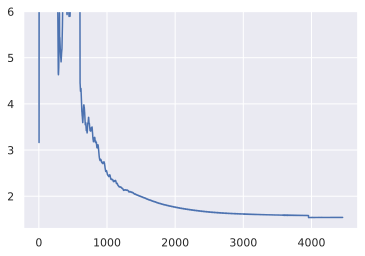

In [14]:
plt.plot(df_part1.index, df_part1['L1_0'])
plt.ylim([1.3, 6])

In [15]:
coeff_keys = [key for key in df_part1.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df_part1.keys() if key[:6]=='scaled']

In [16]:
coeff_keys

['coeff_0_0',
 'coeff_0_1',
 'coeff_0_2',
 'coeff_0_3',
 'coeff_0_4',
 'coeff_0_5',
 'coeff_0_6',
 'coeff_0_7',
 'coeff_0_8',
 'coeff_0_9',
 'coeff_0_10',
 'coeff_0_11']

(-2, 2)

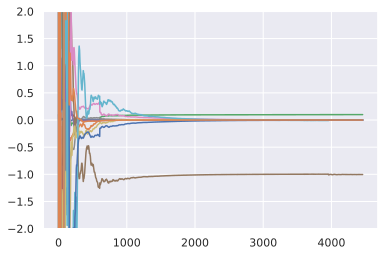

In [17]:
plt.plot(df_part1[coeff_keys])
plt.ylim([-2, 2])

(-2, 2)

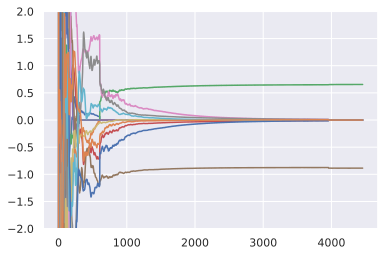

In [18]:
plt.plot(df_part1[scaled_coeff_keys])
plt.ylim([-2, 2])

In [19]:
active_map = df_part1[coeff_keys][::10]
active_map[active_map!=0.0] = 1.0

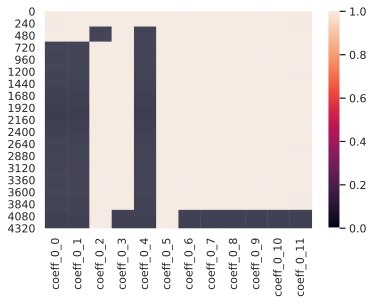

In [20]:
sns.heatmap(active_map)